<a href="https://colab.research.google.com/github/cdixson-ds/DS-Unit-2-Linear-Models/blob/master/LS_DS_214_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [X] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [X] Begin with baselines for classification.
- [X] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [0]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [0]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [0]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [0]:
# Drop some columns to prevent "leakage"

df = df.drop(columns=['Rec', 'overall'])

In [226]:
df.head()

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,1/18/2016,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,1/24/2016,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,1/24/2016,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,1/24/2016,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,1/27/2016,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


Train/validate/test split

In [227]:
#Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.

from datetime import datetime
pd.options.mode.chained_assignment = None

df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
df['Date'].describe
df.shape

(421, 59)

In [0]:
train = df[df['Date'].dt.year <= 2016]
val = df[df['Date'].dt.year == 2017]
test = df[df['Date'].dt.year >= 2018]


Baseline

In [229]:
#Begin with baselines for classification.
#Roughly 40% of burritos are 'great'

target = 'Great'
y_train = train[target]
y_train.value_counts(normalize=True)

False    0.590604
True     0.409396
Name: Great, dtype: float64

In [0]:
#What if we guessed the majority class for every prediction?

majority_class = y_train.mode()[0]
y_pred = [majority_class] * len(y_train)


In [231]:
# Training accuracy of majority class baseline = 
# frequency of majority class (aka base rate)

from sklearn.metrics import accuracy_score

accuracy_score(y_train, y_pred)

0.5906040268456376

In [232]:
#Validation accuracy of majority class baseline=
#usually similar to Train accuracy

y_val = val[target]
y_pred = [majority_class] * len(y_val)
accuracy_score(y_val, y_pred)

0.5529411764705883

Linear Regression

In [233]:
#Start with linear regression for intuition, and fun

train.describe().T

,count,mean,std,min,25%,50%,75%,max
Yelp,71.0,3.897183,0.478680,2.50,3.5000,4.00,4.00,4.50
Google,71.0,4.142254,0.371738,2.90,4.0000,4.20,4.40,4.90
Cost,292.0,6.896781,1.211412,2.99,6.2500,6.85,7.50,11.95
Hunger,297.0,3.445286,0.852150,0.50,3.0000,3.50,4.00,5.00
Mass (g),0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Density (g/mL),0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Length,175.0,19.829886,2.081275,15.00,18.5000,19.50,21.00,26.00
Circum,174.0,22.042241,1.685043,17.00,21.0000,22.00,23.00,27.00
Volume,174.0,0.770920,0.137833,0.40,0.6625,0.75,0.87,1.24
Tortilla,298.0,3.472315,0.797606,1.40,3.0000,3.50,4.00,5.00


In [234]:
#1 Import estimator class
from sklearn.linear_model import LinearRegression

#2 Instantiate this class
linear_reg = LinearRegression()

#3 Arrange X feature matrices(already did y target vectors)
features = ['Fillings', 'Tortilla', 'Temp', 'Yelp', 'Google', 'Cost', 'Hunger', 'Length', 'Circum', 'Volume', 'Meat:filling', 'Uniformity', 'Salsa', 'Synergy', 'Wrap']
#no more than 3 features?

X_train = train[features]
X_val = val[features]

#4 Impute missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)

#5 Fit the model
linear_reg.fit(X_train_imputed, y_train)

linear_reg.predict(X_val_imputed)

array([ 4.59629459e-01,  5.00336082e-01,  6.22112082e-01,  5.52274611e-01,
       -1.51925605e-01,  1.04004826e-01,  8.23107059e-01,  5.08672502e-01,
       -1.70409788e-01,  7.86243293e-01,  7.55231376e-01, -1.46691755e-02,
        2.23344311e-01,  3.06587291e-01,  1.02409648e+00,  4.35329463e-01,
        4.83805105e-01,  6.09326466e-01,  5.89047845e-01,  1.06124307e+00,
        6.27601313e-01,  4.58249811e-01,  1.16734850e-01,  5.17722880e-01,
        6.88997463e-01,  6.04612099e-01,  6.65960121e-01,  3.60527796e-01,
        4.56473830e-01,  5.57149931e-01,  7.80288371e-01,  4.26707045e-01,
        2.50395270e-01,  3.30806118e-01, -3.60861966e-02,  9.86974490e-03,
        3.74702276e-01,  5.84150632e-01,  4.16617674e-01,  6.28356221e-01,
        3.08932411e-01,  4.71890931e-01,  5.11482333e-01,  5.85677855e-01,
        5.79503522e-01,  4.36521445e-01,  1.33290759e-01,  3.15396906e-01,
        6.31253150e-01, -1.50334222e-01,  1.16174565e-01,  4.65089340e-01,
        8.25135451e-01,  

In [235]:
#Get coefficients
pd.Series(linear_reg.coef_, features)

Fillings        0.122041
Tortilla        0.060644
Temp            0.060389
Yelp            0.111010
Google         -0.163567
Cost            0.045113
Hunger          0.006209
Length          0.101441
Circum          0.182075
Volume         -2.641897
Meat:filling    0.076355
Uniformity      0.015462
Salsa           0.041453
Synergy         0.157585
Wrap            0.004014
dtype: float64

In [0]:
#test_case = [[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]] #hot burrito?
#linear_reg.predict(test_case)  

In [0]:
from sklearn.metrics import mean_absolute_error

#y_pred_train = model.predict(X_train_imputed)
#mae = mean_absolute_error(y_train, y_pred_train)
#print(f'Train Error: {mae:.2f} ')

Logistic Regression

In [238]:
#Use scikit-learn for logistic regression
#Is the validation better than the baseline? yes

from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(solver='lbfgs', max_iter=300)
log_reg.fit(X_train_imputed, y_train)
print('Validation Accuracy', log_reg.score(X_val_imputed, y_val))

Validation Accuracy 0.8470588235294118


In [239]:
#This is what predictions look like

log_reg.predict(X_val_imputed)

array([False, False,  True,  True, False, False,  True,  True, False,
        True,  True, False, False, False,  True, False, False,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
       False,  True,  True,  True, False, False, False, False, False,
       False,  True, False,  True, False,  True,  True,  True,  True,
       False, False, False,  True, False, False, False,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False, False, False,  True,  True,  True,  True,
        True, False,  True,  True])

In [240]:
log_reg.predict(test_case)

array([False])

In [241]:
log_reg.predict_proba(test_case)

array([[0.70511218, 0.29488782]])

In [242]:
log_reg.coef_

array([[ 1.50521817,  0.6697534 ,  0.6015295 ,  0.27129933, -0.18532562,
         0.39927913,  0.16003182,  0.05325453,  0.03789849, -0.04400453,
         1.14763786,  0.12967097,  0.38111832,  1.84557395,  0.1412405 ]])

In [0]:
#The logistic sigmoid 'squishing' function, implemented to accept numpy arrays
import numpy as np

def sigmoid(x):
  return 1/ (1 + np.e**(-x))

In [244]:
sigmoid(log_reg.intercept_ + np.dot(log_reg.coef_, np.transpose(test_case)))

array([[0.29488782]])

Get validation accuracy

In [245]:
features = ['Fillings', 'Tortilla', 'Temp', 'Yelp', 'Google', 'Cost', 'Hunger', 'Length', 'Circum', 'Volume', 'Meat:filling', 'Uniformity', 'Salsa', 'Synergy', 'Wrap']
target = 'Great'

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((298, 15), (298,), (85, 15), (85,))

Plot coefficients:

In [0]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler

In [0]:
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

In [248]:
X_train_encoded.head()

,Fillings,Tortilla,Temp,Yelp,Google,Cost,Hunger,Length,Circum,Volume,Meat:filling,Uniformity,Salsa,Synergy,Wrap
0,3.5,3.0,5.0,3.5,4.2,6.49,3.0,NaN,NaN,NaN,4.0,4.0,4.0,4.0,4.0
1,2.5,2.0,3.5,3.5,3.3,5.45,3.5,NaN,NaN,NaN,2.0,4.0,3.5,2.5,5.0
2,3.0,3.0,2.0,NaN,NaN,4.85,1.5,NaN,NaN,NaN,4.5,4.0,3.0,3.0,5.0
3,3.0,3.0,2.0,NaN,NaN,5.25,2.0,NaN,NaN,NaN,4.0,5.0,4.0,4.0,5.0
4,3.5,4.0,5.0,4.0,3.8,6.59,4.0,NaN,NaN,NaN,4.5,5.0,2.5,4.5,4.0


In [249]:
X_val_encoded.head()

,Fillings,Tortilla,Temp,Yelp,Google,Cost,Hunger,Length,Circum,Volume,Meat:filling,Uniformity,Salsa,Synergy,Wrap
301,3.5,4.0,4.5,NaN,NaN,6.60,NaN,23.0,20.5,0.77,3.5,5.0,1.5,3.50,4.5
302,4.0,4.0,2.0,NaN,NaN,6.60,NaN,20.5,21.5,0.75,NaN,4.6,4.2,3.75,5.0
303,3.0,3.0,4.5,NaN,NaN,8.50,3.9,21.0,21.0,0.74,3.7,4.0,4.3,4.20,5.0
304,3.0,3.5,4.0,NaN,NaN,7.90,4.0,20.5,21.0,0.72,4.0,4.5,4.0,3.80,4.8
305,2.5,2.5,4.5,NaN,NaN,4.99,3.5,18.5,22.5,0.75,3.0,3.0,2.0,2.00,4.0


In [0]:
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_val_imputed = imputer.transform(X_val_encoded)

In [251]:
X_train_imputed[:5]

array([[ 3.5       ,  3.        ,  5.        ,  3.5       ,  4.2       ,
         6.49      ,  3.        , 19.82988571, 22.04224138,  0.77091954,
         4.        ,  4.        ,  4.        ,  4.        ,  4.        ],
       [ 2.5       ,  2.        ,  3.5       ,  3.5       ,  3.3       ,
         5.45      ,  3.5       , 19.82988571, 22.04224138,  0.77091954,
         2.        ,  4.        ,  3.5       ,  2.5       ,  5.        ],
       [ 3.        ,  3.        ,  2.        ,  3.8971831 ,  4.14225352,
         4.85      ,  1.5       , 19.82988571, 22.04224138,  0.77091954,
         4.5       ,  4.        ,  3.        ,  3.        ,  5.        ],
       [ 3.        ,  3.        ,  2.        ,  3.8971831 ,  4.14225352,
         5.25      ,  2.        , 19.82988571, 22.04224138,  0.77091954,
         4.        ,  5.        ,  4.        ,  4.        ,  5.        ],
       [ 3.5       ,  4.        ,  5.        ,  4.        ,  3.8       ,
         6.59      ,  4.        , 19.82988571, 

In [252]:
#this line of code turns it back into a pandas dataframe

pd.DataFrame(X_train_imputed, columns=X_train_encoded.columns)

,Fillings,Tortilla,Temp,Yelp,Google,Cost,Hunger,Length,Circum,Volume,Meat:filling,Uniformity,Salsa,Synergy,Wrap
0,3.5,3.0,5.0,3.500000,4.200000,6.49,3.0,19.829886,22.042241,0.77092,4.0,4.0,4.00000,4.0,4.0
1,2.5,2.0,3.5,3.500000,3.300000,5.45,3.5,19.829886,22.042241,0.77092,2.0,4.0,3.50000,2.5,5.0
2,3.0,3.0,2.0,3.897183,4.142254,4.85,1.5,19.829886,22.042241,0.77092,4.5,4.0,3.00000,3.0,5.0
3,3.0,3.0,2.0,3.897183,4.142254,5.25,2.0,19.829886,22.042241,0.77092,4.0,5.0,4.00000,4.0,5.0
4,3.5,4.0,5.0,4.000000,3.800000,6.59,4.0,19.829886,22.042241,0.77092,4.5,5.0,2.50000,4.5,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,3.0,4.0,1.5,4.000000,4.300000,5.65,3.0,19.500000,22.000000,0.75000,4.2,4.0,3.00000,2.0,4.5
294,2.0,4.5,5.0,3.897183,4.142254,5.49,3.0,19.000000,20.500000,0.64000,2.5,3.5,3.00000,2.5,3.0
295,3.3,3.5,2.5,3.500000,3.700000,7.75,4.0,20.000000,21.000000,0.70000,1.4,2.3,2.20000,3.3,4.5
296,2.0,4.0,4.5,3.897183,4.142254,7.75,4.0,19.500000,21.000000,0.68000,3.5,3.5,2.00000,2.0,4.0


In [253]:
X_val_imputed[:5]

array([[ 3.5       ,  4.        ,  4.5       ,  3.8971831 ,  4.14225352,
         6.6       ,  3.4452862 , 23.        , 20.5       ,  0.77      ,
         3.5       ,  5.        ,  1.5       ,  3.5       ,  4.5       ],
       [ 4.        ,  4.        ,  2.        ,  3.8971831 ,  4.14225352,
         6.6       ,  3.4452862 , 20.5       , 21.5       ,  0.75      ,
         3.52886986,  4.6       ,  4.2       ,  3.75      ,  5.        ],
       [ 3.        ,  3.        ,  4.5       ,  3.8971831 ,  4.14225352,
         8.5       ,  3.9       , 21.        , 21.        ,  0.74      ,
         3.7       ,  4.        ,  4.3       ,  4.2       ,  5.        ],
       [ 3.        ,  3.5       ,  4.        ,  3.8971831 ,  4.14225352,
         7.9       ,  4.        , 20.5       , 21.        ,  0.72      ,
         4.        ,  4.5       ,  4.        ,  3.8       ,  4.8       ],
       [ 2.5       ,  2.5       ,  4.5       ,  3.8971831 ,  4.14225352,
         4.99      ,  3.5       , 18.5       , 

In [0]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

In [255]:
X_train_scaled

array([[-0.02244697, -0.59316238,  1.34069563, ...,  0.72124523,
         0.50099338,  0.03868647],
       [-1.20240271, -1.84902306, -0.21386677, ...,  0.18727406,
        -1.13340089,  0.89967866],
       [-0.61242484, -0.59316238, -1.76842918, ..., -0.34669711,
        -0.5886028 ,  0.89967866],
       ...,
       [-0.25843812,  0.03476795, -1.25024171, ..., -1.20105098,
        -0.26172395,  0.46918257],
       [-1.79238058,  0.66269829,  0.82250816, ..., -1.41463945,
        -1.67819898,  0.03868647],
       [-0.61242484,  0.16035402,  0.3043207 , ...,  0.        ,
         0.28307414, -1.6832979 ]])

In [256]:
model = LogisticRegressionCV()
model.fit(X_train_scaled, y_train)
print('Validation Accuracy', model.score(X_val_scaled, y_val))

Validation Accuracy 0.8352941176470589


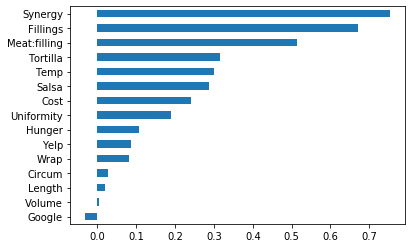

In [257]:
coefficients = pd.Series(model.coef_[0], X_train_encoded.columns)
coefficients.sort_values().plot.barh();

In [258]:
X_train_encoded.columns

Index(['Fillings', 'Tortilla', 'Temp', 'Yelp', 'Google', 'Cost', 'Hunger',
       'Length', 'Circum', 'Volume', 'Meat:filling', 'Uniformity', 'Salsa',
       'Synergy', 'Wrap'],
      dtype='object')

Try with feature selection

In [0]:
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import f_regression, SelectKBest

In [260]:
model = LogisticRegressionCV()
model.fit(X_train_scaled, y_train)
print('Validation Accuracy', model.score(X_val_scaled, y_val))

Validation Accuracy 0.8352941176470589


In [261]:
    selector = SelectKBest(score_func=f_regression, k=15)
    X_train_selected = selector.fit_transform(X_train_scaled, y_train)
    X_test_selected = selector.transform(X_val_scaled)
    model = LogisticRegressionCV()
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    print('Validation Accuracy', model.score(X_val_scaled, y_val))
 

Validation Accuracy 0.8352941176470589


In [0]:
 #Get your model's test accuracy. (One time, at the end.)

X_test = test[features]
y_test = test[target]

In [0]:
X_test_encoded = encoder.fit_transform(X_test)
X_test_imputed = imputer.fit_transform(X_test_encoded)

In [264]:
print('Validation Accuracy', model.score(X_test_imputed, y_test))

Validation Accuracy 0.5789473684210527
